In [2]:
import pyfits
import healpy as hp
import numpy as np
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import sys, os
from astropy import units as u
from astropy.coordinates import SkyCoord
import k3match
from astroquery.gama import GAMA as gama
from astroquery.sdss import SDSS as sdss
import matplotlib.cm as cm
from astropy.io import fits
from astropy.table import Table
#from scipy.optimize import curve_fit, minimize
from lmfit import Parameters, fit_report, minimize, Minimizer
import scipy.constants as sc
from pylab import *
plt.rcParams['figure.figsize'] = [9, 6]
plt.rcParams['figure.dpi'] = 80
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15

In [12]:
def scattomap(dec,ra, nside=16):
    hmap = np.zeros(hp.nside2npix(nside))
    hmap = hmap + np.bincount(hp.ang2pix(nside, np.deg2rad(90.-dec), np.deg2rad(360. - ra)), minlength=hp.nside2npix(nside))
    return hmap

def scattomapweighted(dec,ra, weights, nside=16):
    hmap = np.zeros(hp.nside2npix(nside))
    hmap = hmap + np.bincount(hp.ang2pix(nside, np.deg2rad(90.-dec), np.deg2rad(360. - ra)), weights=weights, minlength=hp.nside2npix(nside))
    return hmap

def EquatorialtoGalactic(ra, dec):
    skc = SkyCoord(ra = ra*u.degree, dec =dec*u.degree)
    return skc.galactic.l.value, skc.galactic.b.value

def GalactictoEquatorial(l, b):
    skc = SkyCoord(l = l*u.degree, b =b*u.degree, frame='galactic')
    return skc.icrs.ra.value, skc.icrs.dec.value

def dAngleDeg(ra1, dec1, ra2, dec2):
    return np.rad2deg(np.arccos(np.cos(np.deg2rad(dec1))*np.cos(np.deg2rad(dec2))*np.cos(np.deg2rad(ra1) - np.deg2rad(ra2))+np.sin(np.deg2rad(dec1))*np.sin(np.deg2rad(dec2))))

def EvaluateDip3Dest(WQtab):
    skc = SkyCoord(ra = WQtab['ra']*u.degree, dec=WQtab['dec']*u.degree).cartesian
    cx = skc.x.value
    cy = skc.y.value
    cz = skc.z.value
    xf = cx.sum()
    yf = cy.sum()
    zf = cz.sum()
    ske = SkyCoord(x=xf, y=yf, z=zf, representation='cartesian').frame.represent_as('spherical')
    dipra = ske.lon.degree
    dipdec = ske.lat.degree
    resdip = np.sqrt(xf*xf + yf*yf + zf*zf)
    dipcmbangle = dAngleDeg(CMBdipra, CMBdipdec, dipra, dipdec)
    print(dipcmbangle, resdip/float(len(cx)), dipra, dipdec, len(cx))
    return dipcmbangle, resdip/float(len(cx)), dipra, dipdec

def EvaluateDip3DestWeighted(WQtab, weights=None):
    #weights = weights/np.sum(weights)
    if weights is None:
        weights = 1.
    else:
        weights = weights/np.sum(weights)
    skc = SkyCoord(ra = WQtab['ra']*u.degree, dec=WQtab['dec']*u.degree).cartesian
    cx = skc.x.value*weights
    cy = skc.y.value*weights
    cz = skc.z.value*weights
    xf = cx.sum()
    yf = cy.sum()
    zf = cz.sum()
    ske = SkyCoord(x=xf, y=yf, z=zf, representation='cartesian').frame.represent_as('spherical')
    dipra = ske.lon.degree
    dipdec = ske.lat.degree
    resdip = np.sqrt(xf*xf + yf*yf + zf*zf)
    dipcmbangle = dAngleDeg(CMBdipra, CMBdipdec, dipra, dipdec)
    print(dipcmbangle, resdip/float(len(cx)), dipra, dipdec, len(cx))
    return dipcmbangle, resdip/float(len(cx)), dipra, dipdec

def EvaluateDipRSSchwarzQuad(W, weights=None, NSIDE=32):
    hm = scattomap(dec = W['dec'], ra = W['ra'], nside=NSIDE)#, weights=weights)
    nonzer=[hm>0]
    def SumToMinimize(pars):
        Nbar, A, ra, dec = pars[0], pars[1], pars[2], pars[3]
        pdec, pra = IndexToDeclRa(np.arange(hp.nside2npix(NSIDE)), NSIDE)
        costp = np.cos(np.deg2rad(dAngleDeg(ra, dec, pra, pdec)))
        nonzer = [hm>0]
        tos = (np.power( (hm - Nbar*(1. +  A*costp)), 2 )/(Nbar*(1. +  A*costp)))
        return np.sum(tos*nonzer) #1810.04960 Eq 17
    
    def lmfittomin(lmpars):
        sppars = list(lmpars.valuesdict().values())
        return SumToMinimize(sppars)
    
    lmp = Parameters()
    
    Nbguess = np.sum(hm[nonzer])/float(len(hm[nonzer]))
    
    rdec, rra = IndexToDeclRa(np.random.choice(np.asarray(range(0, hp.nside2npix(128)))), NSIDE=128)
    
    
    inguess = np.array([Nbguess,   0.011,   rra, rdec])
    
    pnames = ['Nbar', 'A', 'DipRa', 'DipDec']
    
    
    
    bnds = ((Nbguess*0.7, Nbguess*1.5),(0, 1.0), (0,360.),(-90.0,90.0))
    
    for val, name, bnd in zip(inguess, pnames, bnds):
        lmp.add(name, value=val, min=bnd[0], max=bnd[1])
    
    print('Start Val' , lmfittomin(lmp))
    
    minner = Minimizer(lmfittomin, lmp)
    resquad = minner.minimize(method = 'ampgo')# options={'ftol':1.e-2, 'disp':True})
    
    print(resquad)
    dipcmbangle = dAngleDeg(CMBdipra, CMBdipdec, resquad.params['DipRa'].value, resquad.params['DipDec'].value)
    #powcmbdangle = dAngleDeg(CMBpowra, CMBpowdec, resquad.params['DipRa'].value, resquad.params['DipDec'].value)
    mfval = SumToMinimize([resquad.params['Nbar'].value, resquad.params['A'].value, resquad.params['DipRa'].value, resquad.params['DipDec'].value])
    print('result: Dipole Amplitude, ', resquad.params['A'].value, 'RA, Dec' ,resquad.params['DipRa'].value, resquad.params['DipDec'].value, '<toCMB' ,dipcmbangle,  len(W['dec']), mfval)
    return resquad, dipcmbangle,  len(W['dec']), mfval

def IndexToDeclRa(index, NSIDE=32):
    theta,phi=hp.pixelfunc.pix2ang(NSIDE,index)
    return -np.degrees(theta-np.pi/2.),np.degrees(np.pi*2.-phi)

def ApplyIndividualCircularMasks(wq, dec, ra, rad, gal=False):
    if not gal:
        angdeg = dAngleDeg(wq['ra'], wq['dec'], ra, dec)
        angdegop = dAngleDeg(wq['ra'], wq['dec'], ra + 180., -1.*dec)
    else:
        angdeg = dAngleDeg(wq['l'], wq['b'], ra, dec)
        angdegop = dAngleDeg(wq['l'], wq['b'], ra + 180., -1.*dec)
    sel = (angdeg>rad)*(angdegop>rad)
    return wq[sel]

def RemoveHottestRegion(mp, rad, NSIDE=64):
    hm = scattomap(mp['b'], mp['l'], nside=NSIDE)
    decr, rar = IndexToDeclRa(np.argmax(hm), NSIDE)
    print('Removing', decr, rar, np.max(hm), np.argmax(hm))
    return ApplyIndividualCircularMasks(mp, decr, rar, rad, gal=True)

def RemoveHottestRegionNG(mp, rad, NSIDE=64, bc=20):
    mkp = mp[np.absolute(mp['b'])>bc]
    hm = scattomap(mkp['b'], mkp['l'], nside=NSIDE)
    decr, rar = IndexToDeclRa(np.argmax(hm), NSIDE)
    print('Removing', decr, rar, np.max(hm), np.argmax(hm))
    return ApplyIndividualCircularMasks(mp, decr, rar, rad, gal=True)

def RemoveSuperGalacticPlane(w, width):
    sgb = SkyCoord(ra = w['ra']*u.degree, dec=w['dec']*u.degree).supergalactic.sgb.value
    sel = np.absolute(sgb)>width
    return w[sel]

def GetRedShiftEstimatefromGAMA(w):
    selection = np.asarray(gama.query_sql('SELECT s.ra, s.dec, s.z, s.prob FROM SpecAll AS s'))
    selection = selection[selection['prob']>0]
    ovang = 0.0028
    inda,indb,c = k3match.celestial(w['ra'], w['dec'], selection['ra'], selection['DEC'], ovang)
    redshifts = selection[indb]['z']
    print(len(redshifts), ' Matches found with GAMA')
    return redshifts

def GetSDSSCrossmatch(w):
    ovang = 0.00028
    sdsel = np.asarray(sdss.query_sql('SELECT ra, dec, class, z FROM SpecObj'))
    sda, sdb, sdc = k3match.celestial(w['ra'], w['dec'], sdsel['ra'], sdsel['dec'], ovang)
    sdsel = sdsel[sdb]
    wmatch = w[sda]
    return sdsel, wmatch

def GetSDSSCrossmatchLocal(w):
    global sdn
    ovang = 0.00028
    #sdsel = np.asarray(sdss.query_sql('SELECT ra, dec, class, z, zWarning FROM SpecObj', data_release=dr))
    #sdsel = np.asarray(sdss.query_sql('SELECT ra, dec, class, z FROM SpecObj'))
    #selector = (sdn['ZWARNING']==0)*(sdn['SN_MEDIAN_ALL'] > 5)*(sdn['NPOLY'] != 4)
    selector = (sdn['ZWARNING']==0)*(sdn['NPOLY'] != 4)
    selector = selector*(sdn['TARGETTYPE']=="SCIENCE")*(sdn['SPECPRIMARY']==1)*(sdn['SPECLEGACY']==1)
    #selector = selector*(sdn['TARGETTYPE']=="SCIENCE")*(sdn['SPECPRIMARY']==1)
    
    #sdn = sdn[sdn['ZWARNING']==0]
    #sdn = sdn[sdn['SN_MEDIAN_ALL'] > 5]
    #sdn = sdn[sdn['NPOLY'] != 4]
    #sdn = sdn[sdn['SPECPRIMARY']==1]
    sdn = sdn[selector]
    
    sda, sdb, sdc = k3match.celestial(w['ra'], w['dec'], sdn['PLUG_RA'], sdn['PLUG_DEC'], ovang)
    sdsel = sdn[sdb]
    wmatch = w[sda]
    return sdsel, wmatch, sda

def RemoveTWOMRSOverLap(w, zcutt = 0.03, ovang2mrs=0.0028):
    twomrsarr = np.genfromtxt('/lustre/hpc/icecube/mrameez/WDIR/2MRS/catalog/2mrs_1175_done.dat', skip_header=10, usecols=(1,2,24)).transpose()
    print(len(twomrsarr[0]), 'objects loaded from the 2MRS catalog')
    z = twomrsarr[2]/299792.458
    twomrsarr=twomrsarr.transpose()[z<zcutt].transpose()
    print(len(twomrsarr[0]), 'objects left after z < ', zcutt, ' cut')
    inda,indb,c = k3match.celestial(w['ra'], w['dec'], twomrsarr[0],twomrsarr[1], ovang2mrs)
    allindices = np.asarray(range(0, len(w['ra'])))
    selindices = np.delete(allindices, inda, axis=0)
    wr = w[selindices]
    print('Initial, final, diff', len(w['ra']), len(wr['ra']), len(wr['ra']) - len(w['ra']))
    return wr


##Code taken from gammapy. Cite gammapy in paper. Cant get gammapy to install out of pip

def evaluateEllipse(lon, lat, lon_0, lat_0, semi_major, e, theta):
        #ra dec ra dec rad ba pa
        """Evaluate the model (static function)."""
        # find the foci of the ellipse
        c = semi_major * e
        lon_1, lat_1 = offset_by(lon_0, lat_0, 90 - theta, c)
        lon_2, lat_2 = offset_by(lon_0, lat_0, 270 - theta, c)
        
        print(lon_1, lat_1, lon_2, lat_2, semi_major, e, theta)

        sep_1 = dAngleDeg(lon, lat, lon_1, lat_1)
        sep_2 = dAngleDeg(lon, lat, lon_2, lat_2)
        in_ellipse = sep_1 + sep_2 <= 2 * semi_major
        print(len(sep_1), len(sep_1[in_ellipse]))
        return in_ellipse

def offset_by(lon, lat, posang, distance):
    """
    Point with the given offset from the given point.
    Parameters
    ----------
    lon, lat, posang, distance : `Angle`, `~astropy.units.Quantity` or float
        Longitude and latitude of the starting point,
        position angle and distance to the final point.
        Quantities should be in angular units; floats in radians.
        Polar points at lat= +/-90 are treated as limit of +/-(90-epsilon) and same lon.
    Returns
    -------
    lon, lat : `~astropy.coordinates.Angle`
        The position of the final point.  If any of the angles are arrays,
        these will contain arrays following the appropriate `numpy` broadcasting rules.
        0 <= lon < 2pi.
    Notes
    -----
    """
    from astropy.coordinates.angles import Angle

    # Calculations are done using the spherical trigonometry sine and cosine rules
    # of the triangle A at North Pole,   B at starting point,   C at final point
    # with angles     A (change in lon), B (posang),            C (not used, but negative reciprocal posang)
    # with sides      a (distance),      b (final co-latitude), c (starting colatitude)
    # B, a, c are knowns; A and b are unknowns
    # https://en.wikipedia.org/wiki/Spherical_trigonometry

    cos_a = np.cos(np.deg2rad(distance))
    sin_a = np.sin(np.deg2rad(distance))
    cos_c = np.sin(np.deg2rad(lat))
    sin_c = np.cos(np.deg2rad(lat))
    cos_B = np.cos(np.deg2rad(posang))
    sin_B = np.sin(np.deg2rad(posang))

    # cosine rule: Know two sides: a,c and included angle: B; get unknown side b
    cos_b = cos_c * cos_a + sin_c * sin_a * cos_B
    # sin_b = np.sqrt(1 - cos_b**2)
    # sine rule and cosine rule for A (using both lets arctan2 pick quadrant).
    # multiplying both sin_A and cos_A by x=sin_b * sin_c prevents /0 errors
    # at poles.  Correct for the x=0 multiplication a few lines down.
    # sin_A/sin_a == sin_B/sin_b    # Sine rule
    xsin_A = sin_a * sin_B * sin_c
    # cos_a == cos_b * cos_c + sin_b * sin_c * cos_A  # cosine rule
    xcos_A = cos_a - cos_b * cos_c

    A = Angle(np.arctan2(xsin_A, xcos_A), u.radian)
    # Treat the poles as if they are infinitesimally far from pole but at given lon
    # The +0*xsin_A is to broadcast a scalar to vector as necessary
    w_pole = np.argwhere((sin_c + 0*xsin_A) < 1e-12)
    if len(w_pole) > 0:
        # For south pole (cos_c = -1), A = posang; for North pole, A=180 deg - posang
        A_pole = (90*u.deg + cos_c*(90*u.deg-Angle(posang, u.radian))).to(u.rad)
        try:
            A[w_pole] = A_pole[w_pole]
        except TypeError as e: # scalar
            A = A_pole

    outlon = (Angle(lon, u.deg) + A).wrap_at(360.0*u.deg).to(u.deg)
    outlat = Angle(np.arcsin(cos_b), u.radian).to(u.deg)

    return outlon.value, outlat.value



In [6]:
wqasym = pyfits.open('/lustre/hpc/icecube/mrameez/WDIR/WISEQUASARS/export/catwise_agns_masked_final_alpha.fits')[1].data
print(len(wqasym['ra']))

1355352


In [15]:
H0 = 70 #(km/s) / Mpc
SpeedOfLight = 299792.458 # km/s
CMBdipra = 168.0
CMBdipdec = -7.0

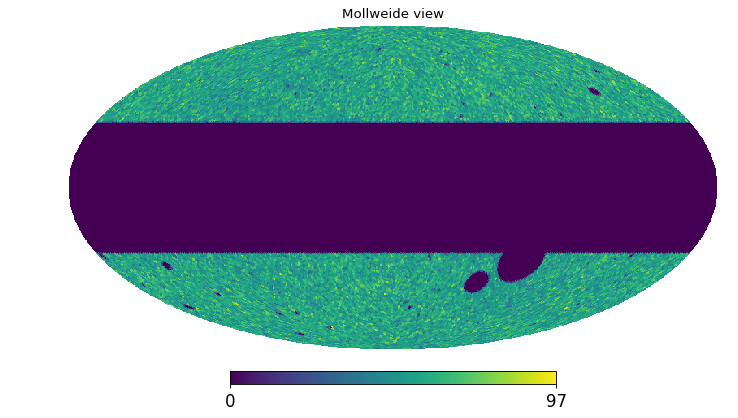

In [7]:
hm = scattomap(wqasym['b'], -1.*wqasym['l'], nside=64)
hp.mollview(hm)
plt.show()


0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


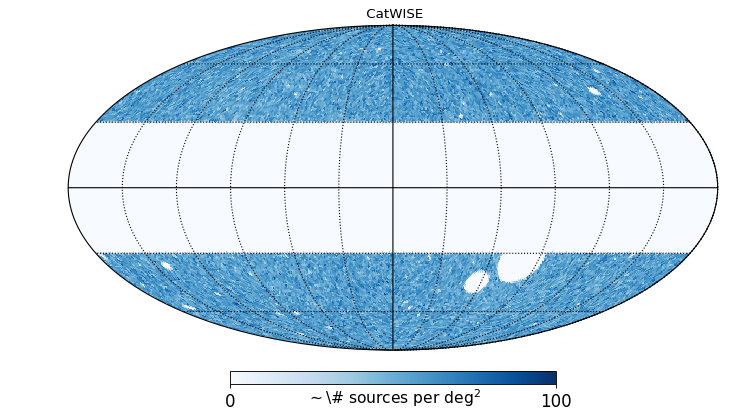

In [10]:
hm = scattomap(wqasym['b'], -1.*wqasym['l'], nside=64)
hp.mollview(hm,rot=(0,0,0),title=r' CatWISE',unit=r'$\sim$\# sources per deg$^2$',min=0,xsize=1200,max=100,cmap=cm.Blues)
hp.graticule()

In [16]:
resquad, dipcmbangle, ln, mfval = EvaluateDipRSSchwarzQuad(wqasym, weights=None, NSIDE=64)

/groups/icecube/mrameez/python35/python/lib/python3.5/site-packages/ipykernel_launcher.py:76: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


Start Val 49472.36878222194
result: Dipole Amplitude,  0.01569272351532669 RA, Dec 142.61374863148413 -1.7679946149432055 <toCMB 25.837043580997683 1355352 48857.960515938


In [14]:
masks = pyfits.open('/lustre/hpc/icecube/mrameez/WDIR/WISEQUASARS/export/exclude_master_final.fits')[1].data
print(masks.columns)

ColDefs(
    name = 'obj'; format = '16A'
    name = 'ra'; format = 'D'
    name = 'dec'; format = 'D'
    name = 'radius'; format = 'D'; unit = 'deg'
    name = 'ba'; format = 'E'
    name = 'pa'; format = 'E'; unit = 'deg'
)


In [18]:
cmasks = masks[masks['pa']<=2]
smasks = masks[masks['pa']>2]
print(len(cmasks['ra']), len(smasks['ra']))

289 3


In [19]:
wq = wqasym

nullras, nulldecs = [], []
for ra, dec, rad in zip(cmasks['ra'], cmasks['dec'], cmasks['radius']):
    angdeg = dAngleDeg(wq['ra'], wq['dec'], ra, dec)
    angdegop = dAngleDeg(wq['ra'], wq['dec'], ra + 180., -1.*dec)
    sel = (angdeg>rad)*(angdegop>rad)
    beflen = len(wq['ra'])
    wq = wq[sel]
    aflen = len(wq['ra'])
    print(ra, dec, rad, aflen, beflen, aflen-beflen)
    if aflen - beflen ==0:
        nullras.append(ra)
        nulldecs.append(dec)

89.983801 45.936787 0.4344521992339051 1355352 1355352 0
79.323681 53.58617 0.3894986887897305 1355352 1355352 0
301.730112 -27.224884 0.5408564334782482 1355352 1355352 0
300.664474 -27.709867 0.4374113016847467 1355352 1355352 0
306.980011 -28.260984 0.5624708239741312 1355280 1355352 -72
76.34878 1.177596 0.39082289731842773 1355280 1355280 0
286.100661 -5.684888 0.35005960628681804 1355280 1355280 0
226.017619 -25.281921 0.5205542541104391 1355280 1355280 0
230.451529 -36.261375 0.35440676238069063 1355280 1355280 0
140.93866 -48.866665 0.3578129050626369 1355280 1355280 0
140.080836 -49.525162 0.41995426862049007 1355280 1355280 0
349.960439 26.278824 0.35495393900331473 1355252 1355280 -28
36.945298 -69.523926 0.35135812430776237 1355229 1355252 -23
82.253672 -4.692465 0.39445730207527846 1355229 1355229 0
59.507396 -13.508624 0.45363024220889875 1355190 1355229 -39
61.078349 -15.72509 0.425957235732263 1355154 1355190 -36
136.999051 -43.432552 0.5729807083750266 1355154 1355154 

0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


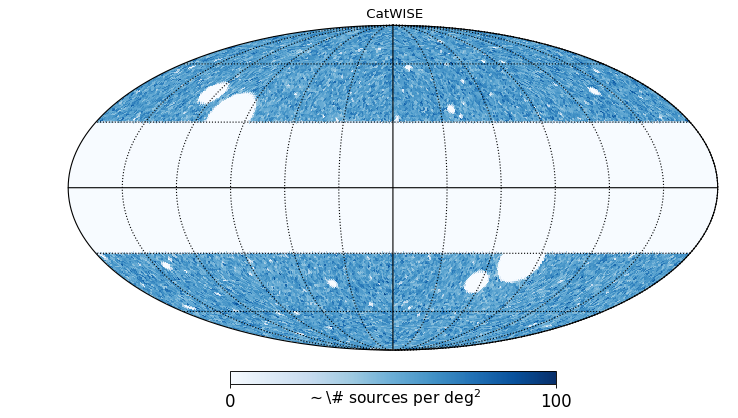

In [20]:
hm = scattomap(wq['b'], -1.*wq['l'], nside=64)
hp.mollview(hm,rot=(0,0,0),title=r' CatWISE',unit=r'$\sim$\# sources per deg$^2$',min=0,xsize=1200,max=100,cmap=cm.Blues)
hp.graticule()

0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


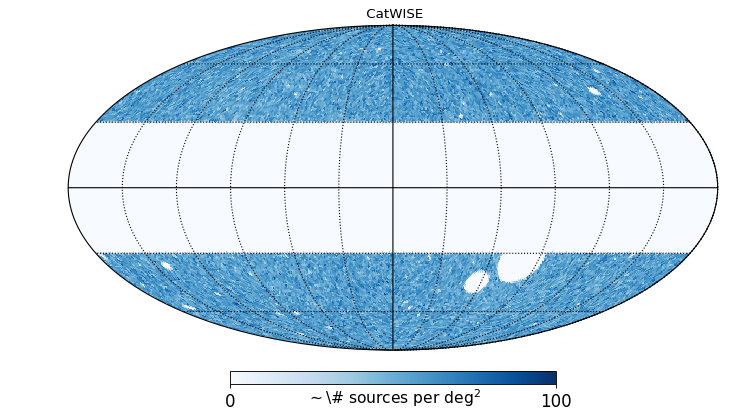

In [23]:
hm = scattomap(wqasym['b'], -1.*wqasym['l'], nside=64)
hp.mollview(hm,rot=(0,0,0),title=r' CatWISE',unit=r'$\sim$\# sources per deg$^2$',min=0,xsize=1200,max=100,cmap=cm.Blues)
hp.graticule()

In [22]:
for ra, dec, rad, ba, pa in zip(smasks['ra'], smasks['dec'], smasks['radius'], smasks['ba'], smasks['pa']):
    ell1 = evaluateEllipse(wq['ra'], wq['dec'], ra, dec, rad, ba, pa)
    ell2 = evaluateEllipse(wq['ra'], wq['dec'], ra+180., -1.*dec, rad, ba, -1.*pa)
    sel = np.invert(ell1)*np.invert(ell2)
    beflen = len(wq['ra'])
    wq = wq[sel]
    aflen = len(wq['ra'])
    print(ra, dec, rad, aflen, beflen, aflen-beflen, ba, pa)

11.89899985181836 42.162512952453625 9.503441167799508 40.362574816470925 2.6911666666666667 0.473 45.0
1323155 0
191.89899985181836 -42.162512952453625 189.50344116779948 -40.362574816470925 2.6911666666666667 0.473 -45.0
1323155 0
10.68471 41.26875 2.6911666666666667 1323155 1323155 0 0.473 45.0
12.080717262266262 -25.073181756566058 11.694716834613587 -25.50416714044643 1.0503333333333333 0.264 51.0
1323155 188
192.08071726226623 25.073181756566058 191.69471683461356 25.50416714044643 1.0503333333333333 0.264 -51.0
1323155 231
11.88806 -25.2888 1.0503333333333333 1322736 1323155 -419 0.264 51.0
24.21068140177391 30.80623305189582 22.71581427868597 30.50936984793948 0.8331666666666666 0.792 13.0
1322736 11
204.2106814017739 -30.80623305189582 202.715814278686 -30.50936984793948 0.8331666666666666 0.792 -13.0
1322736 112
23.4621 30.65994 0.8331666666666666 1322613 1322736 -123 0.792 13.0


In [24]:
wqsym = wq

In [25]:
resquad, dipcmbangle, ln, mfval = EvaluateDipRSSchwarzQuad(wqsym, weights=None, NSIDE=64)

/groups/icecube/mrameez/python35/python/lib/python3.5/site-packages/ipykernel_launcher.py:76: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


Start Val 54013.37151111418
result: Dipole Amplitude,  0.015608035344191584 RA, Dec 137.17611080638713 -3.457845072207178 <toCMB 30.891166774829294 1322613 53228.835833286445


In [27]:
ang, dip, dipra, dipdec = EvaluateDip3Dest(wqsym)

19.874353575122445 0.005509393439652553 162.3803197814234 12.072608152500173 1322613


In [28]:
fits.writeto('/lustre/hpc/icecube/mrameez/WDIR/WISEQUASARS/export/catwise_agns_symmetric_masked_final_alpha.fits',np.array(wqsym))

0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


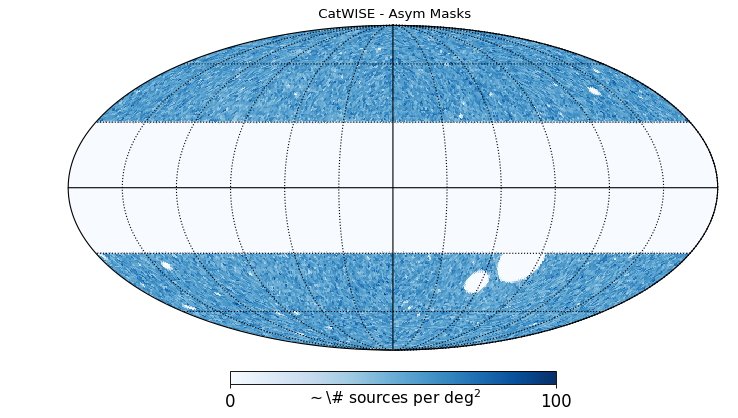

In [29]:
hm = scattomap(wqasym['b'], -1.*wqasym['l'], nside=64)
hp.mollview(hm,rot=(0,0,0),title=r' CatWISE - Asym Masks',unit=r'$\sim$\# sources per deg$^2$',min=0,xsize=1200,max=100,cmap=cm.Blues)
hp.graticule()

0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


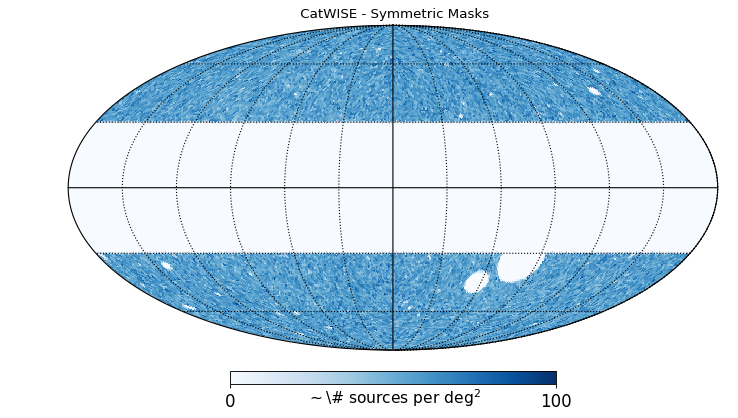

In [30]:
hm = scattomap(wqasym['b'], -1.*wqasym['l'], nside=64)
hp.mollview(hm,rot=(0,0,0),title=r' CatWISE - Symmetric Masks',unit=r'$\sim$\# sources per deg$^2$',min=0,xsize=1200,max=100,cmap=cm.Blues)
hp.graticule()